## Clustering based on audio features

In [105]:
from pymongo import MongoClient
import pandas as pd

# Connect to MongoDB
client = MongoClient("mongodb://localhost:27017/")
db = client["spotify_database"]
collection = db["track_data"]

# Fetch track data from MongoDB, including track_id
cursor = collection.find({}, {"audio_features": 1, "track_name": 1, "track_id": 1, "total_listening_count": 1, "_id": 0})
data = list(cursor)

# Convert to a DataFrame
df = pd.DataFrame(data)

# Extract audio features into a separate DataFrame
audio_features = pd.json_normalize(df["audio_features"])
audio_features["track_name"] = df["track_name"]
audio_features["track_id"] = df["track_id"]  # Include track_id
audio_features["total_listening_count"] = df["total_listening_count"]

# Drop rows with missing values
audio_features.dropna(inplace=True)

In [106]:
from sklearn.preprocessing import StandardScaler

# Extract only the relevant audio features for clustering
selected_features = [
    "danceability", "energy", "loudness", "speechiness",
    "acousticness", "instrumentalness", "liveness", "valence", "tempo"
]

# Normalize the features
scaler = StandardScaler()
audio_features_scaled = scaler.fit_transform(audio_features[selected_features])

# Weight the normalized features by total_listening_count
weighted_features = audio_features_scaled * audio_features["total_listening_count"].values[:, None]

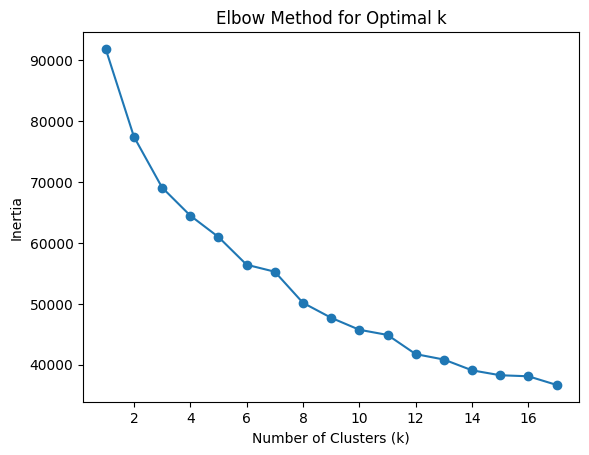

In [107]:
from sklearn.cluster import KMeans
import matplotlib.pyplot as plt

# Use Elbow Method to find the optimal number of clusters
inertia = []
k_values = range(1, 18)

for k in k_values:
    kmeans = KMeans(n_clusters=k, random_state=42)
    kmeans.fit(weighted_features)  # Use weighted features
    inertia.append(kmeans.inertia_)

# Plot the Elbow Curve
plt.plot(k_values, inertia, marker="o")
plt.title("Elbow Method for Optimal k")
plt.xlabel("Number of Clusters (k)")
plt.ylabel("Inertia")
plt.show()

In [108]:
from sklearn.cluster import KMeans

# Choose the optimal number of clusters (e.g., from elbow method)
optimal_k = 4  # Replace with the chosen value from the elbow curve

# Fit K-Means using weighted features
kmeans = KMeans(n_clusters=optimal_k, random_state=1)
audio_features["cluster_id"] = kmeans.fit_predict(weighted_features)

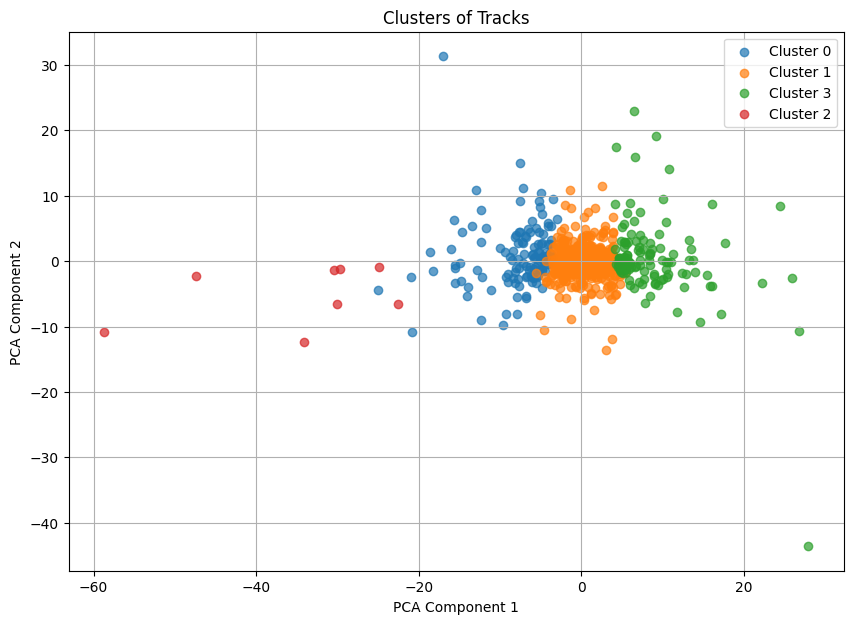

In [109]:
from sklearn.decomposition import PCA
import matplotlib.pyplot as plt

# Reduce dimensions using PCA
pca = PCA(n_components=2)
reduced_features = pca.fit_transform(weighted_features)

# Add PCA results to the DataFrame
audio_features["pca_x"] = reduced_features[:, 0]
audio_features["pca_y"] = reduced_features[:, 1]

# Plot the clusters
plt.figure(figsize=(10, 7))
for cluster_id in audio_features["cluster_id"].unique():
    cluster_points = audio_features[audio_features["cluster_id"] == cluster_id]
    plt.scatter(cluster_points["pca_x"], cluster_points["pca_y"], label=f"Cluster {cluster_id}", alpha=0.7)

plt.title("Clusters of Tracks")
plt.xlabel("PCA Component 1")
plt.ylabel("PCA Component 2")
plt.legend()
plt.grid(True)
plt.show()

In [110]:
# Filter for only numeric columns in audio_features
numeric_columns = audio_features.select_dtypes(include=["number"]).columns

# Group by cluster_id and calculate the mean for numeric features
cluster_summary = audio_features.groupby("cluster_id")[numeric_columns].mean()

print("Cluster Summary (Average Feature Values for Each Cluster):")
print(cluster_summary)

Cluster Summary (Average Feature Values for Each Cluster):
            danceability    energy       key   loudness      mode  \
cluster_id                                                          
0               0.604409  0.753827  5.503937  -5.790748  0.700787   
1               0.562244  0.515000  4.964613  -8.695147  0.804718   
2               0.683750  0.764500  3.500000  -4.847625  0.750000   
3               0.430986  0.207588  5.264463 -16.807777  0.884298   

            speechiness  acousticness  instrumentalness  liveness   valence  \
cluster_id                                                                    
0              0.071094      0.110590          0.023289  0.156624  0.574551   
1              0.053614      0.470094          0.075548  0.163489  0.382912   
2              0.078238      0.125029          0.000169  0.172625  0.787250   
3              0.038493      0.876545          0.393049  0.135450  0.200540   

                 tempo  time_signature  total_liste

Cluster 0:  
Energetic and vibrant tracks with moderate danceability and high energy. These tracks have a bright and upbeat vibe, making them ideal for active or motivational settings like daytime work sessions or workouts.

Cluster 1:  
Relaxed and moderately acoustic tracks with balanced energy. These tracks are introspective and chill, perfect for reflective moments or unwinding after a busy day.

Cluster 2:  
Highly danceable, lively, and upbeat tracks with strong valence. These tracks exude happiness and positivity, making them well-suited for parties, celebrations, or social gatherings.

Cluster 3:  
Calm, acoustic, and melancholic tracks with a strong focus on instrumental qualities. These tracks are emotional and deep, making them ideal for late-night or introspective listening sessions.

In [111]:
import numpy as np

# Find top 5 representative tracks for each cluster
cluster_centroids = kmeans.cluster_centers_

representative_tracks = {}
for cluster_id in range(optimal_k):
    # Explicitly copy the subset of the DataFrame
    cluster_tracks = audio_features[audio_features["cluster_id"] == cluster_id].copy()
    centroid = cluster_centroids[cluster_id]
    
    # Calculate the distance to the centroid
    cluster_tracks["distance_to_centroid"] = cluster_tracks[selected_features].apply(
        lambda row: np.linalg.norm(row.values - centroid), axis=1
    )
    
    # Sort tracks by distance to centroid and pick the top 5
    top_tracks = cluster_tracks.nsmallest(5, "distance_to_centroid")
    representative_tracks[cluster_id] = top_tracks["track_name"].tolist()

# Print top 5 representative tracks for each cluster
print("Top 5 Representative Tracks for Each Cluster:")
for cluster_id, tracks in representative_tracks.items():
    print(f"Cluster {cluster_id}:")
    for i, track in enumerate(tracks, 1):
        print(f"  {i}. {track}")

Top 5 Representative Tracks for Each Cluster:
Cluster 0:
  1. Not Dead Yet
  2. Me and My Friends Are Lonely
  3. Coincidence
  4. Feel It Still
  5. Meet Me in the Woods
Cluster 1:
  1. The Only Thing Left
  2. Unspend
  3. The Elevator
  4. Little bit
  5. this is what slow dancing feels like
Cluster 2:
  1. Tough Love
  2. Pink Pony Club
  3. After Midnight
  4. Taste
  5. Good Luck, Babe!
Cluster 3:
  1. Not Much
  2. The French Library
  3. Clouds
  4. Moon River
  5. Ylang Ylang


In [112]:
# Iterate over each track in audio_features and update MongoDB
for _, row in audio_features.iterrows():
    track_id = row["track_id"]  # Use track_id as the unique identifier
    cluster_id = row["cluster_id"]
    
    # Update the corresponding track in MongoDB
    collection.update_one(
        {"track_id": track_id},  # Match based on track_id
        {"$set": {"cluster_id": int(cluster_id)}}  # Update cluster_id
    )

print("Cluster IDs successfully added to MongoDB!")

Cluster IDs successfully added to MongoDB!


## Temporal Analysis

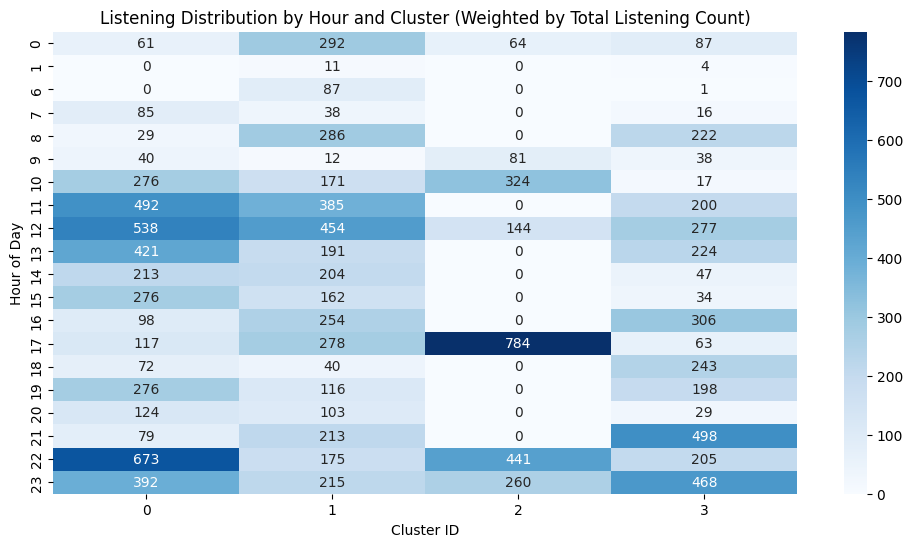

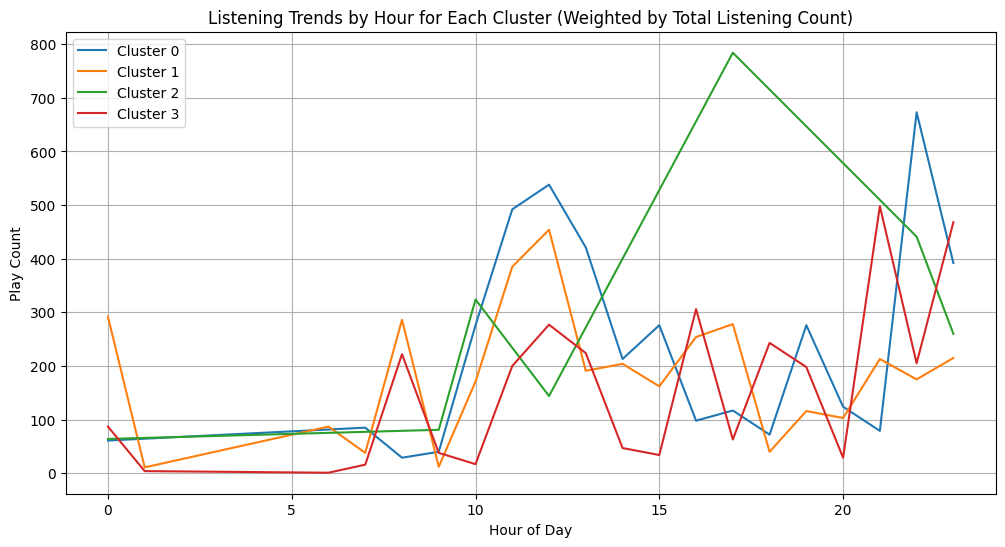

In [115]:
from datetime import datetime
import seaborn as sns
import matplotlib.pyplot as plt
import pandas as pd

# Fetch track data with listening history and clusters
cursor = collection.find({}, {
    "audio_features": 1,
    "track_name": 1,
    "listening_history": 1,
    "cluster_id": 1,
    "total_listening_count": 1,  # Include listening count
    "_id": 0
})
data = list(cursor)

# Convert to a DataFrame
df = pd.DataFrame(data)

# Explode listening_history into separate rows
listening_history = df.explode("listening_history")

# Normalize listening_history into columns
listening_history_normalized = pd.json_normalize(listening_history["listening_history"])
listening_history = listening_history.join(listening_history_normalized)

# Drop rows without valid played_at timestamps
listening_history.dropna(subset=["played_at"], inplace=True)

# Convert played_at to datetime and extract hour of the day
listening_history["played_at"] = pd.to_datetime(listening_history["played_at"])
listening_history["hour"] = listening_history["played_at"].dt.hour

# Add cluster and total listening count information
listening_history["cluster_id"] = listening_history["cluster_id"].fillna(-1).astype(int)  # Ensure cluster IDs are integers
listening_history["total_listening_count"] = listening_history["total_listening_count"].fillna(1).astype(int)  # Default count

# Exclude rows with cluster_id -1
listening_history = listening_history[listening_history["cluster_id"] != -1]

# Group by hour and cluster, summing listening counts
temporal_distribution = listening_history.groupby(["hour", "cluster_id"])["total_listening_count"].sum().reset_index(name="play_count")

# Pivot for easier visualization
temporal_pivot = temporal_distribution.pivot(index="hour", columns="cluster_id", values="play_count").fillna(0)

# Plot temporal distribution of clusters
plt.figure(figsize=(12, 6))
sns.heatmap(temporal_pivot, cmap="Blues", annot=True, fmt=".0f")
plt.title("Listening Distribution by Hour and Cluster (Weighted by Total Listening Count)")
plt.xlabel("Cluster ID")
plt.ylabel("Hour of Day")
plt.show()

# Plot total listening counts per cluster by hour
plt.figure(figsize=(12, 6))
for cluster_id in temporal_distribution["cluster_id"].unique():
    cluster_data = temporal_distribution[temporal_distribution["cluster_id"] == cluster_id]
    plt.plot(cluster_data["hour"], cluster_data["play_count"], label=f"Cluster {cluster_id}")

plt.title("Listening Trends by Hour for Each Cluster (Weighted by Total Listening Count)")
plt.xlabel("Hour of Day")
plt.ylabel("Play Count")
plt.legend()
plt.grid(True)
plt.show()

 - Heatmap: The heatmap shows the listening distribution by hour and cluster, weighted by the total listening count.

    Certain clusters dominate during specific hours of the day, indicating different music preferences at different times.  
    For example, Cluster 0 may have higher play counts during the morning hours (e.g., 9 AM to 11 AM), while Cluster 2 peaks during the late afternoon or evening.  
    The absence of Cluster -1 ensures the analysis focuses on properly categorized tracks.
   
   
 - Line Plot: The line plot highlights the listening trends by hour for each cluster.

    Cluster 0: Peaks during morning and evening hours, indicating energetic or upbeat tracks are preferred during work hours or winding-down time.  
    Cluster 1: Has a consistent listening pattern throughout the day but doesn’t dominate any specific hour.  
    Cluster 2: Shows a clear peak during the late afternoon or early evening, possibly representing music for relaxation or social activities.  
    Cluster 3: Shows sporadic peaks, indicating highly emotional or specific-purpose music.